In [37]:
from F4 import PNL_per_day, DumpCSV_and_MesToTele, position_input, position_report, BacktestInformation
import pandas as pd
import datetime
import numpy as np
import time
import requests
from time import sleep
from ta.volume import MFIIndicator 
from ta.momentum import RSIIndicator, AwesomeOscillatorIndicator, StochasticOscillator
from ta.trend import MACD, CCIIndicator, ADXIndicator
from ta.volatility import BollingerBands, AverageTrueRange

In [85]:
import sys 
sys.path.append('C:\python\ps\duahettienday\Gui_Huy')
from get_data_vn import get_data_ps

ModuleNotFoundError: No module named 'get_data_vn'

In [86]:
data = get_data_ps(10000)

NameError: name 'get_data_ps' is not defined

In [ ]:
data.set_index('Date').Close.plot(figsize = (18,6))

In [98]:
# Low-pass filter dùng cho lọc nhiễu data
from scipy.signal import butter,lfilter 
def lowpass_filter(signal, ratio):
    b, a = butter(1, ratio, btype='low', analog=False)
    filtered_signal = lfilter(b, a, signal)
    return filtered_signal

In [99]:
#path to expiration_date file
df = pd.read_csv('./expiration_date.csv') 
df['Date'] = pd.to_datetime(df['Date'])
expiration_date = set(map(lambda x: x.date(), df['Date']))
expiration_date

{datetime.date(2077, 10, 21),
 datetime.date(2229, 7, 16),
 datetime.date(2107, 7, 21),
 datetime.date(2078, 12, 15),
 datetime.date(2234, 10, 16),
 datetime.date(2031, 7, 17),
 datetime.date(2133, 5, 21),
 datetime.date(2069, 10, 17),
 datetime.date(2017, 1, 19),
 datetime.date(2117, 3, 18),
 datetime.date(2203, 3, 17),
 datetime.date(2124, 8, 17),
 datetime.date(2148, 12, 19),
 datetime.date(2178, 9, 17),
 datetime.date(2139, 7, 16),
 datetime.date(2191, 9, 15),
 datetime.date(2158, 8, 17),
 datetime.date(2254, 2, 16),
 datetime.date(2184, 4, 15),
 datetime.date(2131, 10, 18),
 datetime.date(2236, 3, 17),
 datetime.date(2213, 6, 17),
 datetime.date(2217, 10, 16),
 datetime.date(2030, 4, 18),
 datetime.date(2115, 3, 21),
 datetime.date(2187, 6, 21),
 datetime.date(2172, 7, 16),
 datetime.date(2019, 3, 21),
 datetime.date(2067, 12, 15),
 datetime.date(2158, 1, 19),
 datetime.date(2119, 10, 19),
 datetime.date(2115, 1, 17),
 datetime.date(2084, 7, 20),
 datetime.date(2182, 2, 21),
 date

In [ ]:
import sys#Thay Z bằng tên ổ nas máy cá nhân
sys.path.append('Z:\Data\API_Chien')
from get_data_vn import get_data_ps
#Lấy dữ liệu phái sinh
data=get_data_ps(3000)
data = data.set_index("Date")
data = data.resample('10Min').agg({'Open': 'first', 'Close': 'last', 'High': 'max', 'Low': 'min', 'Volume': 'sum'}).dropna()
data = data.reset_index() 

In [161]:
# data

In [ ]:
# data.to_csv('data1min.csv')

In [117]:
data = pd.read_csv('./data1min.csv')

In [118]:
data.Date = pd.to_datetime(data.Date, errors='coerce')
data = data.set_index("Date")
data = data.resample('10Min').agg({'Open': 'first', 'Close': 'last', 'High': 'max', 'Low': 'min', 'Volume': 'sum'}).dropna()
data = data.reset_index() 

In [169]:
import numpy as np
import pandas as pd
import datetime
from ta.momentum import RSIIndicator
from ta.trend import EMAIndicator
from ta.volume import MFIIndicator
from ta.volatility import AverageTrueRange

def alpha(data, params, expiration_date=set(), point_value=1.0):
    """
    data: DataFrame có cột ['Date','Open','High','Low','Close','Volume'] (Date là datetime64)
    params: dict các tham số
        - t1: hệ số lowpass (nếu dùng)
        - w1: window MFI
        - w2: window ATR
        - t2,t3,t4,t5: ngưỡng hysteresis của MFI (enter/exit)
        - atr_p_low, atr_p_high: percentile bộ lọc ATR (vd 40, 95)
        - risk_budget: rủi ro USD/điểm hoặc đơn vị vốn cho mỗi lệnh
        - atr_mult_sl: số ATR cho stop-loss (vd 2.0)
        - atr_mult_trail: số ATR cho trailing (vd 1.5)
        - max_size: giới hạn size tuyệt đối
        - use_trend_filter: bool
        - ema_window: cửa sổ EMA
        - cooldown_bars: số bar không giao dịch sau khi bị stop
    """
    data = data.copy()

    # --- 1) Chuẩn bị giá (tùy chọn lowpass) ---
    close_src = data['Close'].copy()
    if 't1' in params and params['t1'] is not None:
        # Nếu bạn đã có lowpass_filter riêng, bật dòng dưới.
        # close_src = pd.Series(lowpass_filter(data['Close'].values, params['t1']), index=data.index)
        pass
    data['Close_filtered'] = close_src

    # --- 2) Chỉ báo ---
    data['MFI'] = MFIIndicator(
        high=data['High'], low=data['Low'],
        close=data['Close_filtered'], volume=data['Volume'],
        window=params.get('w1', 14)
    ).money_flow_index()

    atr_obj = AverageTrueRange(
        high=data['High'], low=data['Low'],
        close=data['Close_filtered'], window=params.get('w2', 14)
    )
    data['ATR'] = atr_obj.average_true_range()

    if params.get('use_trend_filter', False):
        ema = EMAIndicator(close=data['Close_filtered'], window=params.get('ema_window', 50)).ema_indicator()
        data['EMA'] = ema
        data['EMA_slope'] = data['EMA'].diff()
    else:
        data['EMA'] = np.nan
        data['EMA_slope'] = np.nan

    # --- 3) Bộ lọc biến động bằng percentile ATR ---
    atr_p_low  = params.get('atr_p_low', 40)
    atr_p_high = params.get('atr_p_high', 95)
    # Dùng rolling percentile để thích nghi (ví dụ 60 phiên/bar gần nhất)
    roll = params.get('atr_regime_window', 60)
    data['ATR_pctl'] = (
        data['ATR']
        .rolling(roll, min_periods=10)
        .apply(lambda x: 100.0 * (x.rank(pct=True).iloc[-1]) if len(x) else np.nan, raw=False)
    )
    data['atr_ok'] = (data['ATR_pctl'] >= atr_p_low) & (data['ATR_pctl'] <= atr_p_high)

    # --- 4) Ngưỡng MFI (hysteresis) ---
    t2 = params.get('t2', 30)  # enter short if MFI < t2
    t3 = params.get('t3', 70)  # enter long  if MFI > t3
    t4 = params.get('t4', 59)  # exit short if MFI > t4
    t5 = params.get('t5', 37)  # exit long  if MFI < t5

    # --- 5) Trend filter logic (tùy chọn) ---
    def allow_long(i):
        if not params.get('use_trend_filter', False):
            return True
        return (data['Close_filtered'].iat[i] > data['EMA'].iat[i]) and (data['EMA_slope'].iat[i] > 0)

    def allow_short(i):
        if not params.get('use_trend_filter', False):
            return True
        return (data['Close_filtered'].iat[i] < data['EMA'].iat[i]) and (data['EMA_slope'].iat[i] < 0)

    # --- 6) Quản trị rủi ro dựa trên ATR ---
    risk_budget     = params.get('risk_budget', 100)         # ví dụ $100 rủi ro cho mỗi lệnh
    atr_mult_sl     = params.get('atr_mult_sl', 2.0)         # stop-loss 2*ATR
    atr_mult_trail  = params.get('atr_mult_trail', 1.5)      # trailing 1.5*ATR
    max_size        = params.get('max_size', 5.0)            # giới hạn size
    cooldown_bars   = params.get('cooldown_bars', 0)         # vd 5 bar nghỉ sau stop

    # --- 7) Vòng lặp để quản lý vị thế, time rule, đáo hạn ---
    pos = 0
    size = 0.0
    entry_price = np.nan
    stop_price = np.nan
    trail_active = False
    cooldown = 0

    positions   = []
    sizes       = []
    entries     = []
    stops       = []
    reasons     = []

    for i in range(len(data)):
        price = data['Close_filtered'].iat[i]
        mfi   = data['MFI'].iat[i]
        atr   = data['ATR'].iat[i]
        atr_ok = bool(data['atr_ok'].iat[i]) if not np.isnan(data['atr_ok'].iat[i]) else False

        # time/expiry rules
        dti = data['Date'].iat[i]
        is_1425 = (isinstance(dti, pd.Timestamp) and dti.time() == datetime.time(14,25))
        is_1445 = (isinstance(dti, pd.Timestamp) and dti.time() == datetime.time(14,45))
        is_expiry = (isinstance(dti, pd.Timestamp) and dti.date() in expiration_date)

        reason = ""

        # cooldown sau stop-out
        if cooldown > 0:
            cooldown -= 1

        # --- EXIT RULES (trước) ---
        if pos == 1:
            # exit long bằng MFI hysteresis
            if mfi < t5:
                reason = "exit_long_MFI"
                pos = 0
            # stop-loss / trailing
            elif not np.isnan(stop_price) and price <= stop_price:
                reason = "stop_long"
                pos = 0
                cooldown = max(cooldown, cooldown_bars)
            else:
                # trailing stop cho long
                if atr > 0:
                    new_trail = price - atr_mult_trail * atr
                    if np.isnan(stop_price):
                        stop_price = price - atr_mult_sl * atr   # khởi tạo từ SL
                        trail_active = True
                    else:
                        # chỉ nâng stop (không hạ)
                        stop_price = max(stop_price, new_trail)

        elif pos == -1:
            # exit short bằng MFI hysteresis
            if mfi > t4:
                reason = "exit_short_MFI"
                pos = 0
            # stop-loss / trailing
            elif not np.isnan(stop_price) and price >= stop_price:
                reason = "stop_short"
                pos = 0
                cooldown = max(cooldown, cooldown_bars)
            else:
                # trailing stop cho short
                if atr > 0:
                    new_trail = price + atr_mult_trail * atr
                    if np.isnan(stop_price):
                        stop_price = price + atr_mult_sl * atr
                        trail_active = True
                    else:
                        stop_price = min(stop_price, new_trail)

        # Quy tắc thoát cuối ngày / đáo hạn (ưu tiên)
        if pos != 0 and is_1425:
            reason = "eod_exit_14_25"
            pos = 0
        if is_1445 and is_expiry and pos != 0:
            reason = "expiry_reset_14_45"
            pos = 0

        # --- ENTRY RULES (sau khi xét exit) ---
        if pos == 0 and cooldown == 0 and atr_ok and atr > 0:
            # tính size theo ATR (risk parity)
            # rủi ro/1 đơn vị vị thế ~ ATR * point_value
            unit_risk = atr * float(point_value)
            raw_size  = risk_budget / unit_risk if unit_risk > 0 else 0.0
            this_size = float(np.clip(raw_size, 0.0, max_size))

            # tín hiệu vào lệnh
            if mfi > t3 and allow_long(i):
                pos = 1
                size = this_size
                entry_price = price
                stop_price = price - atr_mult_sl * atr
                trail_active = True
                reason = "enter_long_MFI_ATR"
            elif mfi < t2 and allow_short(i):
                pos = -1
                size = this_size
                entry_price = price
                stop_price = price + atr_mult_sl * atr
                trail_active = True
                reason = "enter_short_MFI_ATR"
            else:
                # không vào -> reset các biến liên quan
                size = 0.0
                entry_price = np.nan
                stop_price = np.nan
                trail_active = False

        # nếu flat thì reset một số biến
        if pos == 0:
            size = 0.0
            entry_price = np.nan if "enter" not in reason else entry_price
            if "enter" not in reason:
                stop_price = np.nan
                trail_active = False

        positions.append(pos)
        sizes.append(size)
        entries.append(entry_price)
        stops.append(stop_price)
        reasons.append(reason)

    data['pos'] = positions                # hướng vị thế (+1/-1/0)
    data['size'] = sizes                   # kích thước vị thế theo ATR
    data['entry_price'] = entries          # giá vào lệnh (để backtest)
    data['stop_price'] = stops             # stop-loss/trailing hiện tại
    data['signal_reason'] = reasons        # nguyên nhân tín hiệu (debug/giải thích)

    return data


In [163]:
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True, connected=True)

In [156]:
import pandas as pd

In [170]:
params = {
    "w1": 14, "w2": 14,
    "t2": 30, "t3": 70, "t4": 59, "t5": 37,   # hysteresis cho MFI
    "atr_p_low": 40, "atr_p_high": 95,        # lọc ATR theo percentile
    "atr_regime_window": 60,                   # cửa sổ rolling để tính percentile
    "risk_budget": 100, "atr_mult_sl": 2.0, "atr_mult_trail": 1.5,
    "max_size": 5.0,
    "use_trend_filter": True, "ema_window": 50,
    "cooldown_bars": 5
}


In [171]:
# params = {'w1': 14, 'w2': 14, 'w3': 14, 'w4': 14, 't1': 0.75, 't2': 13, 't3': 81, 't4': 59, 't5': 37, 'w1': 14}
ds = alpha(data, params)

In [159]:
ds

Loading ITables v2.5.2 from the internet... (need help?)


In [152]:
import warnings
warnings.filterwarnings("ignore")

Margin: 17.08
MDD: 70.4 (4.52%)

   Total trading quantity: 538
         Profit per trade: 3.44
             Total Profit: 2055.5
         Profit after fee: 1848.3
 Trading quantity per day: 0.28
 Profit per day after fee: 0.97
                   Return: 0.16
          Profit per year: 242.59
                  HitRate: 0.51
          HitRate per day: 0.3


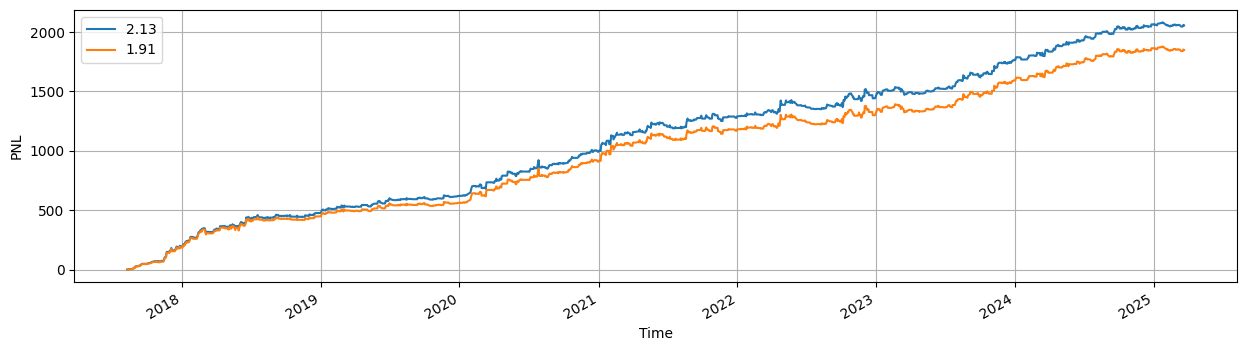

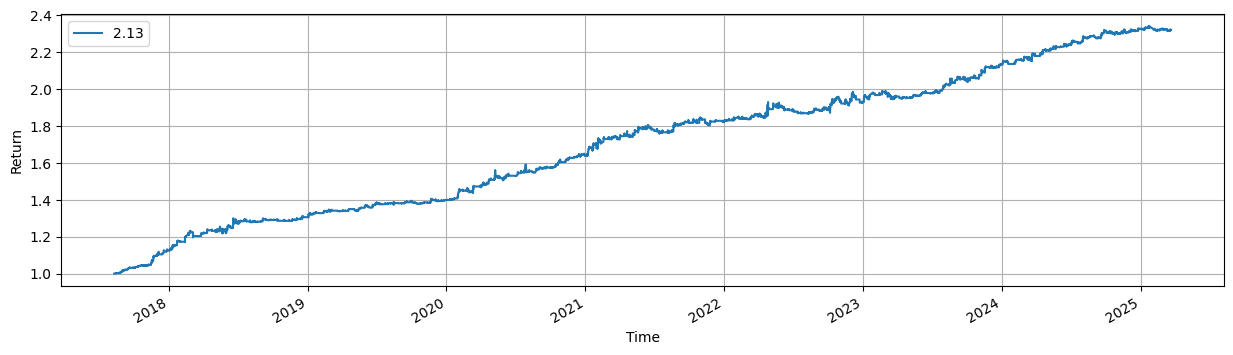

In [168]:
backtestInfo = BacktestInformation(ds['Date'], ds['pos'], ds['Close'], fee = 0.3) 
pnl = backtestInfo.Plot_PNL()

In [150]:
ds.pos

Loading ITables v2.5.2 from the internet... (need help?)


In [151]:
pnl

Loading ITables v2.5.2 from the internet... (need help?)
